In [21]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
import os
import copy
import math
from gensim import corpora
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# FUNCTIONS AND GLOBALS

In [4]:
with open('input/languages.txt', 'r') as file:
    languages = [f.strip('\n') for f in file.readlines()]

In [13]:
def read_text(datatype, folder, filename):
    with open(os.path.join(datatype, folder, filename), 'r') as file:
        return file.read()
    
def get_wordcount_by_lang(text_dict, unique=False):
    if unique:
        dictionaries = {lan: corpora.Dictionary([text_dict[lan]]) for lan in text_dict.keys()}
        return {k: len(v) for k, v in dictionaries.items()}
    else:
        return {k: len(v) for k, v in text_dict.items()}

# READ CORPUS

In [6]:
files = {lan: os.listdir(os.path.join('page_text', lan)) for lan in languages}

In [7]:
# plain texts
texts = {lan: {f[:-4]: read_text('page_text', lan, f).lower() 
               for f in files[lan]} 
         for lan in languages}

# CREATE TOKENIZED TEXT

In [9]:
# tokenized text - remove punctuation
tokenizer = RegexpTokenizer(r'\w+')
texts_split = {lan: {key: tokenizer.tokenize(text) for key, text in texts[lan].items()} for lan in languages}

# JOIN TEXT BY LANGUAGE

In [10]:
text_bylang = {lan: sum([val for key, val in texts_split[lan].items()], []) for lan in languages}

# WORDCOUNTS FOR RAW TEXT

In [38]:
df_wordcounts_raw = pd.DataFrame(index = languages)
df_wordcounts_raw['countRaw'] = df_wordcounts_raw.index.map(get_wordcount_by_lang(text_bylang))
df_wordcounts_raw['countUnique'] = df_wordcounts_raw.index.map(get_wordcount_by_lang(text_bylang, True))
df_wordcounts_raw

,countRaw,countUnique
en,3191139,91738
de,1673767,134302
hu,818669,111097
ro,547997,56173


# BARPLOT FOR RAW TEXT

Text(0.5, 0.98, 'Word counts and unique word counts by languages')

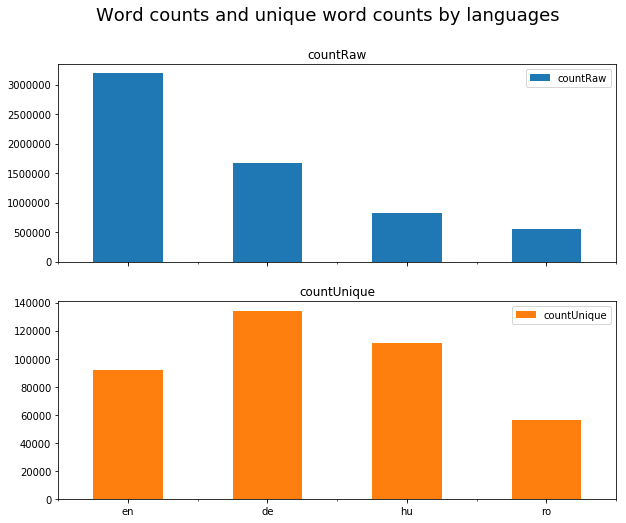

In [53]:
ax = df_wordcounts_raw.plot.bar(rot=0, subplots=True, figsize=(10,8))
fig = plt.gcf()
fig.suptitle('Word counts and unique word counts by languages', fontsize=18)

# STOPWORD REMOVAL

In [39]:
# long format of languages for stopword identification
languages_long = {'en': 'english', 'de': 'german', 'hu': 'hungarian', 'ro': 'romanian'}

# create dict of stopwords by language
stopwords_bylang = {lan: set(stopwords.words(languages_long[lan])) for lan in languages}

# filter stopwords from text
text_bylang_stop = {lan: [f for f in text_bylang[lan] if not f in stopwords_bylang[lan]] for lan in languages}

# WORDCOUNTS FOR STOPWORD REMOVED TEXT

In [40]:
df_wordcounts_nostop = pd.DataFrame(index = languages)
df_wordcounts_nostop['countRaw'] = df_wordcounts_nostop.index.map(get_wordcount_by_lang(text_bylang_stop))
df_wordcounts_nostop['countUnique'] = df_wordcounts_nostop.index.map(get_wordcount_by_lang(text_bylang_stop, True))
df_wordcounts_nostop

,countRaw,countUnique
en,1955467,91586
de,1088246,134076
hu,609245,110909
ro,365645,55894


# BARPLOT FOR STOPWORD REMOVED  TEXT

Text(0.5, 0.98, 'Word counts and unique word counts by languages after stopword removal')

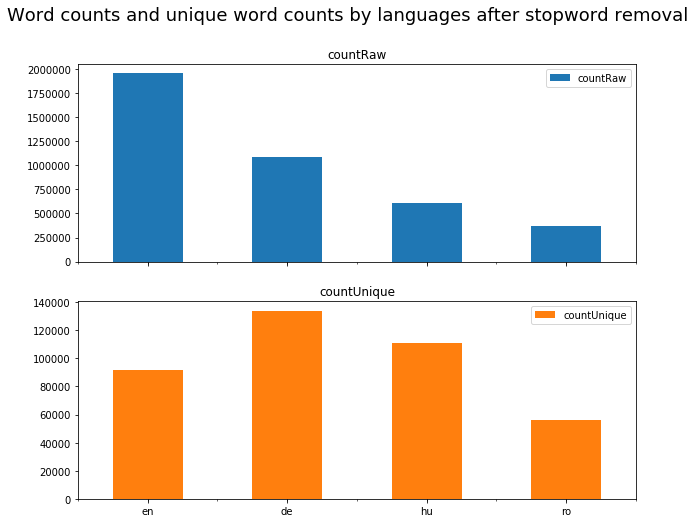

In [52]:
ax = df_wordcounts_nostop.plot.bar(rot=0, subplots=True, figsize=(10,8))
fig = plt.gcf()
fig.suptitle('Word counts and unique word counts by languages after stopword removal', fontsize=18)

# STEMMING TEXT

In [54]:
# define stemmer objects by language
stemmers = {lan: SnowballStemmer(languages_long[lan]) for lan in languages}

# stem text
text_bylang_stemmed = {lan: [stemmers[lan].stem(word) for word in text_bylang[lan]] for lan in languages}

# stem and remove stopwords
text_bylang_stop_stemmed = {lan: [stemmers[lan].stem(word) for word in text_bylang_stop[lan]] for lan in languages}

# WORDCOUNTS FOR STOPWORD REMOVED TEXT

* now only unique counts make sense

In [55]:
df_wordcounts_stem_stop = pd.DataFrame(index = languages)
df_wordcounts_stem_stop['stemOnly'] = df_wordcounts_nostop.index.map(get_wordcount_by_lang(text_bylang_stemmed, True))
df_wordcounts_stem_stop['stemStop'] = df_wordcounts_nostop.index.map(get_wordcount_by_lang(text_bylang_stop_stemmed, True))
df_wordcounts_stem_stop

,stemOnly,stemStop
en,70851,70750
de,101670,101604
hu,67584,67549
ro,36962,36798


# BARPLOT FOR STEMMED AND STOPWORD REMOVED  TEXT

Text(0.5, 0.98, 'Word counts and unique word counts by languages after stopword removal')

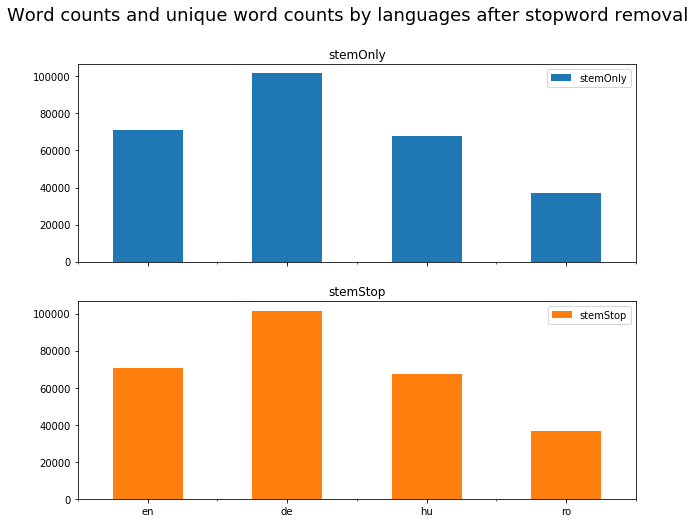

In [61]:
ax = df_wordcounts_stem_stop.plot.bar(rot=0, subplots=True, figsize=(10,8))
fig = plt.gcf()
fig.suptitle('Word counts and unique word counts by languages after stopword removal', fontsize=18)

# COMPARE TO RAW COUNTS

In [63]:
# get divisor -> raw unique counts
df_wordcounts_stem_stop['rawUnique'] = df_wordcounts_raw['countUnique']

In [71]:
# divide to get ratios to raw unique counts
for col in ['stemOnly', 'stemStop']:
    df_wordcounts_stem_stop[f'{col}_ratio'] = df_wordcounts_stem_stop[col] / df_wordcounts_stem_stop['rawUnique']

# BARPLOT OF RATIOS TO RAW TEXT

Text(0.5, 0.98, 'Ratio of unique words kept by languages after stemming only, and after stemming+stopword removal')

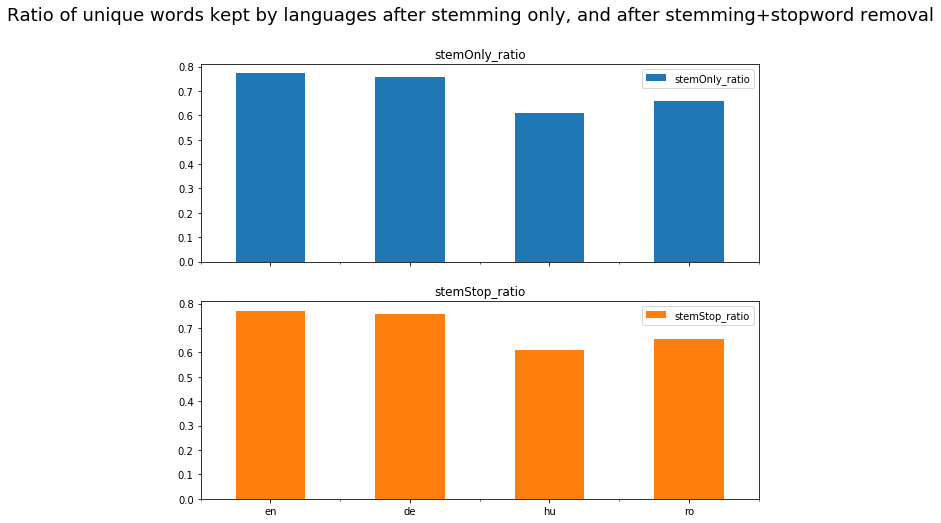

In [76]:
ax = df_wordcounts_stem_stop[[f for f in df_wordcounts_stem_stop.columns if 'ratio' in f]].plot.bar(rot=0, subplots=True, figsize=(10,8))
fig = plt.gcf()
fig.suptitle('Ratio of unique words kept by languages after stemming only, and after stemming+stopword removal', fontsize=18)

# AGGREGATED INFORMATION FROM THIS PART

## RAW COUNTS

In [89]:
counts_sum_df = pd.DataFrame(index=languages)
counts_sum_df['Raw'] = df_wordcounts_raw[['countRaw']]
counts_sum_df['NoStop'] = df_wordcounts_nostop['countRaw']
counts_sum_df['Stemmed'] = counts_sum_df['NoStop']
counts_sum_df['NoStopStemmed'] = counts_sum_df['Stemmed']

In [90]:
counts_sum_df

,Raw,NoStop,Stemmed,NoStopStemmed
en,3191139,1955467,1955467,1955467
de,1673767,1088246,1088246,1088246
hu,818669,609245,609245,609245
ro,547997,365645,365645,365645


## UNIQUE COUNTS

In [91]:
uniques_sum_df = pd.DataFrame(index=languages)
uniques_sum_df['Raw'] = df_wordcounts_raw['countUnique']
uniques_sum_df['NoStop'] = df_wordcounts_nostop['countUnique']
uniques_sum_df['Stemmed'] = df_wordcounts_stem_stop['stemOnly']
uniques_sum_df['NoStopStemmed'] = df_wordcounts_stem_stop['stemStop']

In [92]:
uniques_sum_df

,Raw,NoStop,Stemmed,NoStopStemmed
en,91738,91586,70851,70750
de,134302,134076,101670,101604
hu,111097,110909,67584,67549
ro,56173,55894,36962,36798


# SPARSE TERM REMOVAL

## CREATE STEMMED, STOPWORD REMOVED CORPUS BY DOC

In [93]:
texts_bylang_byhuman = {lan:
                        {key:
                         [stemmers[lan].stem(word) 
                          for word in val if not word in stopwords_bylang[lan]] 
                         for key, val in texts_split[lan].items()} 
                        for lan in languages}

In [94]:
dictionary_bylang_byhuman = {lan: corpora.Dictionary(texts_bylang_byhuman[lan].values()) for lan in languages}

## REMOVE SPARSE TERMS

In [95]:
# create sparsity thresholds for percentages
sparse_perc = [1, 5, 10, 20]
sparse_thresh = [math.ceil(f * len(texts['en'].keys()) / 100) for f in sparse_perc]

In [96]:
# remove sparse tokens
filtered_dicts = {}
for lan in languages:
    filtered_dicts[lan] = {}
    for i, t in enumerate(sparse_thresh):
        filtered_dicts[lan][sparse_perc[i]] = copy.copy(dictionary_bylang_byhuman[lan])
        filtered_dicts[lan][sparse_perc[i]].filter_extremes(no_below=t)

In [97]:
# create word counts for filtered dictionaries
word_counts_filtered = {lan: {k: len(v) for k,v in filtered_dicts[lan].items()} for lan in languages}

## ABSOLUTE WORD COUNTS

In [110]:
sparse_df = pd.DataFrame.from_dict(get_wordcount_by_lang(text_bylang_stop_stemmed, True), orient='index')
sparse_df.columns = ['no removal']
sparse_df_ = pd.DataFrame.from_dict(word_counts_filtered).T
sparse_df = sparse_df.join(sparse_df_)
sparse_df

In [111]:
sparse_df

,no removal,1,5,10,20
en,70750,13959,4704,2703,1319
de,101604,15346,3985,1895,670
hu,67549,10800,2490,1063,371
ro,36798,6783,1593,646,166


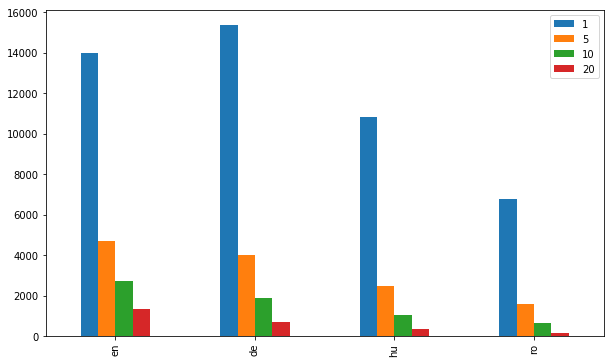

In [126]:
# plot absolute counts in a grouped barchart
sparse_df.drop('no removal', axis=1).plot.bar(figsize=(10,6))

## RELATIVE WORD COUNTS

In [113]:
sparse_df_perc = sparse_df.copy()
for i in [1,5,10,20]:
    sparse_df_perc[i] /= sparse_df_perc['no removal']
sparse_df_perc['no removal'] = 1

In [114]:
sparse_df_perc

,no removal,1,5,10,20
en,1,0.197300,0.066488,0.038205,0.018643
de,1,0.151037,0.039221,0.018651,0.006594
hu,1,0.159884,0.036862,0.015737,0.005492
ro,1,0.184331,0.043290,0.017555,0.004511


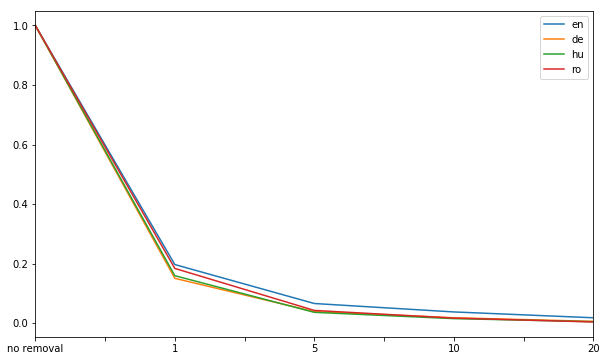

In [127]:
# plot linechart to show decline
sparse_df_perc.T.plot(figsize=(10,6))

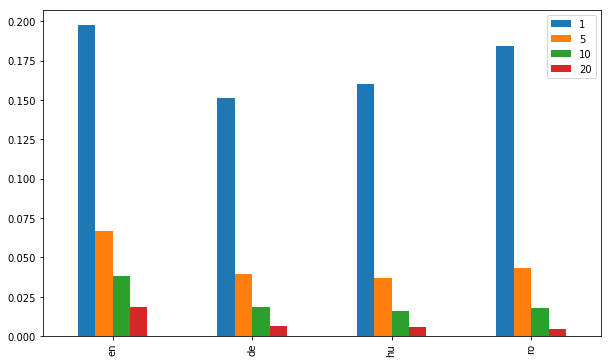

In [128]:
# plot relative counts in a grouped barchart
sparse_df_perc.drop('no removal', axis=1).plot.bar(figsize=(10,6))

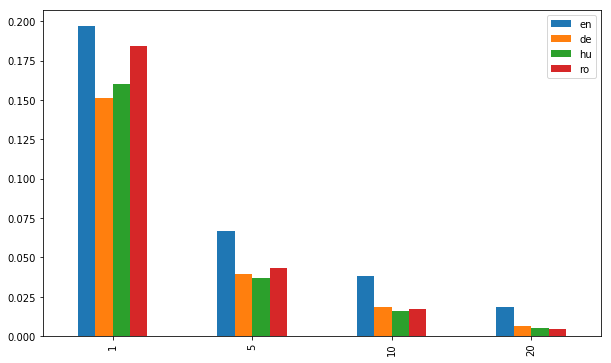

In [129]:
# plot relative counts in a grouped barchart
sparse_df_perc.drop('no removal', axis=1).T.plot.bar(figsize=(10,6))